## Map the side effect with the frequency via search through text corpus

In this notebook, I demonstrate the step by which the frequency of side effects (from using drug) was obtained
- 1. Open the list of unique side effects from Side_effect_analysis_1_topic extraction,ipynb
- 2. Engineer topic/keyword features to keep "meaningful" side effects
    - 1. Stemmize the list of side effects 
        - stem_dictionary.pickle: maps side effect to stemmized side effect 
    - 2. Then took only 'NN' from the text using POS tagging (total 232 unique side effectss) 
- 3. Fuzzy search (first five character match)stemmed side effects through corpora of patients text  
- 4. Save the search as  "data/procesed/side_effect_without_stem/%s_SE_freq.pkl" % (drug_name) ; dictionary that has a mapping of side_effect key words: frequency in the corpora

In [1]:
from pathlib import Path
import pickle 
import os 
import sys
import pandas as pd 
import re 
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.analys import * 

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

### 1. Open the list of unique side effects from Side_effect_analysis_1_topic extraction,ipynb : top_5_metioned

In [119]:
f_n = []
with os.scandir() as it:
    for entry in it:
        if entry.name.endswith('pkl') :
            f_n.append(entry.name)
print (f_n)

['Effexor_top5_commanti_dep.pkl', 'Lexapro_top5_commanti_dep.pkl', 'Prozac_top5_commanti_dep.pkl', 'Wellbutrin_top5_commanti_dep.pkl', 'Zoloft_top5_commanti_dep.pkl']


#### Sample output: 

In [120]:
# 1. Search string that contains certain drugs
df = pd.read_pickle(f_n[0])
print (len(df))
drug_name =  (f_n[0].split('_')[0])
print (drug_name)

        
D= pd.Series(df['selftext_bysent'].values.tolist()[15])
K= D.str.contains(drug_name, flags=re.IGNORECASE, regex=True)
print (K)
print(D[K[K==True].index].values) 
print (D.values)

849
Effexor
0    True
dtype: bool
['I had to discontinue effexor due to the headaches :( I was on it maybe a month']
['I had to discontinue effexor due to the headaches :( I was on it maybe a month']


In [9]:
cwd = Path.cwd()
external_data_fd = '../data/external'
processed_data_fd = '../data/processed'

In [ ]:
newpath_1 = r'{}//side_effect_without_stem'.format((cwd/ processed_data_fd).resolve())
onlyfiles = [f for f in os.listdir(newpath_1) sif "SE" in f]

In [10]:
print (onlyfiles)

['SE_topic_Anafranil.pkl', 'SE_topic_Asendin.pkl', 'SE_topic_Aventyl.pkl', 'SE_topic_Celexa.pkl', 'SE_topic_Cipralex.pkl', 'SE_topic_Cymbalta.pkl', 'SE_topic_Desyrel.pkl', 'SE_topic_Effexor.pkl', 'SE_topic_Elavil.pkl', 'SE_topic_Emsam.pkl', 'SE_topic_Etrafon.pkl', 'SE_topic_fluvoxamine.pkl', 'SE_topic_Lexapro.pkl', 'SE_topic_Limbitrol.pkl', 'SE_topic_Ludiomil.pkl', 'SE_topic_Marplan.pkl', 'SE_topic_Nardil.pkl', 'SE_topic_nefazodone.pkl', 'SE_topic_Norpramin.pkl', 'SE_topic_Pamelor.pkl', 'SE_topic_Parnate.pkl', 'SE_topic_Paxil.pkl', 'SE_topic_Pexeva.pkl', 'SE_topic_Prozac.pkl', 'SE_topic_Remeron.pkl', 'SE_topic_Sarafem.pkl', 'SE_topic_Seroquel.pkl', 'SE_topic_Sinequan.pkl', 'SE_topic_Surmontil.pkl', 'SE_topic_Symbyax.pkl', 'SE_topic_Tofranil-PM.pkl', 'SE_topic_Tofranil.pkl', 'SE_topic_Triavil.pkl', 'SE_topic_Vivactil.pkl', 'SE_topic_Wellbutrin.pkl', 'SE_topic_Zoloft.pkl', 'SE_topic_Zyban.pkl']


#### Retreive the list of all topics in side effects from Side_effect_analysis_1_topic extraction

In [122]:
drug_name_SE = [re.split('_|; |.pkl|\*|\n',f)[2] for f in onlyfiles]
nm = newpath_1 + "all_SE.txt"
with open(nm, "rb") as fp:   
    all_SE  = pickle.load(fp)

Effexor


In [123]:
print (len(all_SE))

704


### 2. Engineer topic/keyword features to keep "meaningful" side effects

The purpose of extracing topics from side effect is to inform new patients with the likely occurence of side effects. To acheive this, here I firstly extracted topics/key words in side effects from survey results and then search those keywords through corpus of patients' experience (reddit). Frequency is then inferred from the search result and cmopiled for each drug. In order to achieve this, it's important to extract "meaningful" topic/keywords from the side effects. To get "meaningful" topic, I implemented three steps; firstly I used TextRank - a graph based topic model to extract topic/keywords. These keywords were stemmed to remove duplicates that are in different forms and finally were then tagged for their "part-of-speech" - the idea here is 1) see whether topic/keywords is represented mainly by nouns, which one would intuitively guess what topic model'd generate. 2) and keeping 'NN' would make the most sense.  

    - 0. EDA on POS of SE key words 
    - 1. Stemmize the list of side effects 
        - stem_dictionary.pickle: maps side effect to stemmized side effect 
    - 2. Then took only 'NN' from the text using POS tagging (total 232 unique side effectss) 

0. EDA on POS of SE key words 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mskang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
704


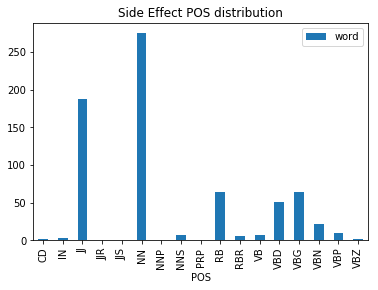

In [124]:
# EDA on SE list 
import nltk
nltk.download('averaged_perceptron_tagger')
all_SE_POS= nltk.pos_tag(all_SE) 
df = pd.DataFrame(all_SE_POS, columns=['word', 'POS'])
df.groupby('POS').count().plot(kind='bar', subplots=True)
plt.title("Side Effect POS distribution")
plt.savefig("POS_All_SE.png")

The graph above shows in fact, NN(singular noun) + jj (adjective) takes > 80% of case. 
1. Stemmize the list of side effects 
    - stem_dictionary.pickle: maps side effect to stemmized side effect 

500


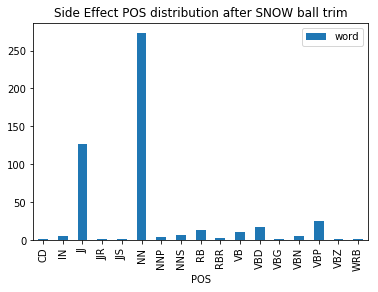

In [126]:
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict
stemmer2 = SnowballStemmer("english")

# Create the dictionary of side effect : stemmed side effect to look up the words later 
stemm_dict=defaultdict(list)
for x in all_SE:
    stemm_dict[x].append(stemmer2.stem(x))
fnm = "%s/stem_dictionary.pickle" %(newpath_1)
with open(fnm, 'wb') as handle:
    pickle.dump(stemm_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Stemmize SE : Snowball 
all_SE_test = [stemmer2.stem(x) for x in all_SE]
all_SE_test = list(set(all_SE_test))
print (len(all_SE_test))

# POS tagging stemmized SE 
all_SE_POS= nltk.pos_tag(all_SE_test) 
df = pd.DataFrame(all_SE_POS, columns=['word', 'POS'])
df.groupby('POS').count().plot(kind='bar', subplots=True)
plt.title("Side Effect POS distribution after SNOW ball trim")
plt.savefig("POS_SnowballStemmed_All_SE.png")

In [107]:
print (len(df[df['POS']=='NN']['word'].unique()))
print(len(df[df['POS']=='NN']['word']))

232
232


Snowball gave the list of words were interpretable enough to understand 
Also using NN tag is able to capture most of the topics 

2. Then took only 'NN' from the text using POS tagging (total 232 unique side effectss) 

In [108]:
all_SE = df[df['POS']=='NN']['word'].values # After Snowball stemming

In [113]:
all_SE = df[df['POS']=='NN']['word'].unique()
print (all_SE)

['block' 'burn' 'overact' 'remeron' 'mild' 'beer' 'concentr' 'heart'
 'quick' 'medic' 'blocker' 'syndrom' 'cymbalta' 'constip' 'sinus' 'hr'
 'happi' 'sensit' 'st' 'care' 'son' 'focus' 'caffein' 'throat' 'sedat'
 'caus' 'lisfranc' 'level' 'death' 'shaki' 'breast' 'terribl' 'rash'
 'thank' 'drug' 'bodi' 'steadi' 'issu' 'alcohol' 'tri' 'tardiv' 'room'
 'pressur' 'hair' 'head' 'cheerio' 'toler' 'thing' 'eat' 'loss' 'cigarett'
 'movement' 'use' 'insomnia' 'sex' 'sore' 'reflux' 'today' 'rem' 'alot'
 'paxil' 'flush' 'anxieti' 'deperson' 'hell' 'food' 'hunger' 'lot'
 'reaction' 'harm' 'drank' 'irrit' 'horribl' 'fix' 'bc' 'mid' 'patch'
 'veget' 'stress' 'list' 'midnight' 'agit' 'loo' 'lb' 'didnt' 'bit'
 'snris' 'easili' 'voic' 'hypo' 'vertigo' 'w' 'massiv' 'drive' 'year'
 'symptom' 'rumbl' 'restasi' 'itch' 'attack' 'alert' 'edgi' 'orgasm' 'cr'
 'liquid' 'concern' 'brain' 'ask' 'slowli' 'dark' 'clench' 'maker'
 'method' 'week' 'cramp' 'layer' 'paralysi' 'asleep' 'help' 'birth' 'tire'
 'hand' 'di

### 3. Fuzzy search stemmed side effects through corpora of patients text  
- To infer the frequency of side effect from using drug, I counted the occurence of side effects (as prepared above) in the reddit corpora for each drug. Since side effects are stemmed, I've implemented a function to allow "fuzzy matchcing". Through trying different methods (i.e. match by half of length, match by first n words) I used the following function to assign occurence

function assigns match when first four words exact match for words longer than five characters or exact match for shorter characters. Having said that, this is not the only way to allow fuzzy matching. I haven't yet tried more sophisticated methods of matching

In [97]:
from collections import Counter 
import math

def lookup_words(word1, word2):
    len_word1 = len(word1)
    len_word2 = len(word2)
    if (len_word1 >5) &  (len_word2 >5):
        if Counter(word1[:4]) == Counter(word2[:4]): 
            exp =True
        else: 
            exp=False  
    else: 
        if Counter(word1) == Counter(word2): 
            exp =True
        else: 
            exp=False 
    return exp 

print(lookup_words("effect", "effectively"))
print(lookup_words("effect", "effected"))
print(lookup_words("apple", "appretty"))

True
True
False


In [98]:
def lookup_SE(df, col,SE_list):
    """
    Return df with new column, which contrains the words in side effect 
    df: preprocessed text on subreddit comments corpus and 
    dict_a: counts the occurences of the side effect match key:side_ effect, item: number of occurences
    words= those that match the side effect terms
    """
    df['words_in_SE']= [[]]*len(df[col])
    tupl = list(zip(SE_list, [0]*len(SE_list)))
    dict_a = dict(tupl)
    for ind,wds in zip(df[col].index,df[col].values):
        words = []
        for wd in wds:
            for se in SE_list:
                if lookup_words(wd,se):
                    words.append(wd)
                    dict_a[se] +=1          
        df.at[ind,'words_in_SE'] = list(set(words))
    return dict_a, words, df

### 4. Calculate frequency for each drug and save the reuslt 
Output looks like dictionary that has a mapping of side_effect key words: frequency in the corpora  
"data/procesed/side_effect_without_stem/%s_SE_freq.pkl" % (drug_name) ; 


In [99]:
onlyfiles = [f for f in os.listdir(newpath_1) if "SE" in f]

Example case = Effecxor 

In [4]:
# df is the pre-processed data frame for a givne drug with columns = 'selftext_bysent' 'selftext_byWords', 'sentiment_body'
df = pd.read_pickle(f_n[0])
drug_name = (f_n[0].split('_')[0])
dict_a, words, df = lookup_SE(df,'selftext_byWords',all_SE)

NameError: name 'pd' is not defined

In [101]:
print (df['words_in_SE'].head())
print (dict_a)
print (words)
print (df.head())
fnm = newpath_1 + "/%s_SE_freq.pkl" % (drug_name)
with open(fnm, 'wb') as handle:
    pickle.dump(dict_a, handle, protocol=pickle.HIGHEST_PROTOCOL)

28                                  [life, day, effexor]
29     [dose, week, completed, attached, plan, attack...
76     [time, work, thing, anxiety, effexor, smoke, d...
97     [doctor, work, patch, increasing, cymbalta, ef...
118    [libido, different, doctor, month, slowly, ear...
Name: words_in_SE, dtype: object
{'burn': 0, 'concentr': 31, 'quick': 3, 'syndrom': 25, 'cymbalta': 81, 'son': 0, 'focus': 8, 'caffein': 3, 'death': 7, 'shaki': 0, 'breast': 33, 'drug': 137, 'alcohol': 28, 'room': 3, 'aggress': 3, 'toler': 0, 'thing': 123, 'till': 2, 'cigarett': 1, 'movement': 0, 'use': 38, 'nardil': 3, 'today': 24, 'rem': 1, 'horribl': 47, 'fix': 11, 'mid': 4, 'tast': 1, 'abdomin': 0, 'easili': 42, 'voic': 0, 'vertigo': 4, 'w': 0, 'drive': 34, 'calori': 28, 'rumbl': 0, 'attack': 20, 'liquid': 3, 'pustular': 6, 'week': 84, 'layer': 17, 'mood': 57, 'start': 90, 'restless': 67, 'confus': 13, 'headach': 31, 'anger': 7, 'race': 19, 'step': 4, 'function': 32, 'prozac': 116, 'herb': 1, 'smoke': 

Doing it for all drugs

In [102]:
for i in range(len(f_n)):
    df = pd.read_pickle(f_n[i])
    drug_name = (f_n[i].split('_')[0])
    dict_a, words, df = lookup_SE(df,'selftext_byWords',all_SE)
    fnm = newpath_1 + "/%s_SE_freq.pkl" % (drug_name)
    with open(fnm, 'wb') as handle:
        pickle.dump(dict_a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    fnm_1 = newpath_1 + "/%s_Df_SE_freq.pkl" % (drug_name)
    df.to_pickle(fnm_1)

In [103]:
with open( fnm, 'rb') as handle:
    b = pickle.load(handle)
print (b)
unpickled_df = pd.read_pickle(fnm_1)
print (unpickled_df['words_in_SE'].head())

{'burn': 1, 'concentr': 33, 'quick': 3, 'syndrom': 13, 'cymbalta': 50, 'son': 1, 'focus': 17, 'caffein': 7, 'death': 8, 'shaki': 0, 'breast': 25, 'drug': 87, 'alcohol': 38, 'room': 4, 'aggress': 5, 'toler': 0, 'thing': 142, 'till': 2, 'cigarett': 4, 'movement': 2, 'use': 30, 'nardil': 9, 'today': 22, 'rem': 2, 'horribl': 26, 'fix': 5, 'mid': 2, 'tast': 0, 'abdomin': 0, 'easili': 27, 'voic': 0, 'vertigo': 2, 'w': 0, 'drive': 34, 'calori': 38, 'rumbl': 0, 'attack': 26, 'liquid': 4, 'pustular': 9, 'week': 99, 'layer': 9, 'mood': 71, 'start': 89, 'restless': 110, 'confus': 28, 'headach': 17, 'anger': 13, 'race': 24, 'step': 9, 'function': 13, 'prozac': 169, 'herb': 0, 'smoke': 6, 'b': 0, 'jitter': 1, 'faint': 0, 'dont': 36, 'dose': 255, 'hypoten': 8, 'lack': 14, 'site': 1, 'blood': 16, 'cycl': 0, 'pamelor': 3, 'dosag': 0, 'plan': 10, 'person': 298, 'mayb': 0, 'diarrhea': 7, 'overact': 45, 'beer': 2, 'heart': 11, 'medic': 0, 'blocker': 0, 'constip': 99, 'lisfranc': 0, 'level': 14, 'anxti': 